<a href="https://colab.research.google.com/github/riti-agarwal/SURF/blob/main/SURF_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outlier Detection in Astronomical time series Data
In the realm of astronomical research, our project aims to revolutionize the way astronomers interact with vast time series datasets generated by a large telescope. With data pouring in every 48 hours, the challenge lies in sifting through millions of observations to pinpoint anomalies of scientific interest. Our goal was to develop an algorithm using topological data analysis to accurately detect these anomalies. By doing so, we not only streamline the data analysis process but empower astronomers worldwide to focus on the most intriguing and scientifically significant events.

Overall summary of code:

1: generate test data

2: Generate persistence diagram for each graph

3: Compare persistence diagrams using WS distance metric, to produce a distance matrix

4: Apply Isolation Forest on this distance matrix to identify outliers


In [ ]:
# Importing and installing necessary libraries

!pip install ripser
!pip install persim
!pip install scipy


import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from ripser import ripser
from persim import plot_diagrams
import persim
from sklearn.datasets import make_blobs
from numpy import quantile, random, where
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 1. Generate test data

The telescope data was received as a time series of each part of the sky depicting the light intensity of the stars in that region.

Since I cannot use real data from the telescope, I am using synthetic data graphs for testing. I use uniform distribution to generate 20 amplitude and period values and then generate 400 sine curves from a combination of these values.

Since Uniform distribution is used, the dataset itself has some anomalies, but we add 4 more anomolous graphs to this dataset

In [4]:
# Generate 400 synthetic data graphs for testing

# Generate Amplitude and Period for the test data sine graphs
def getAandP():
  # generating 20 amplitude values between 0 and 1
  tempA = np.random.uniform(0, 1, 20)
  A = tempA.tolist()
  # generating 20 period values between 0.5 and 10
  tempP = np.random.uniform(0.5, 10, 20)
  P = tempP.tolist()
  return A, P


# choosing time step for the time series as 3, this can be changed to whatever
# Generating values divisible by 3 up to 200
def getXvalues():
  x_values = np.arange(0, 200, 3)
  x = np.array(x_values)
  npts = len(x)
  return x, npts


# Generate y values given x values with the correct amplitude and period
def getData(x, amp, period):
    y = amp * np.sin(2. * np.pi * x / period)
    return np.array([x, y])


**Generate 4 graphs with anomalous data**

Calculating the x and y values for abnormal time series - we use these as anomalies in our test data
* Tan anomaly
* Random points on a circle anomaly
* Exponential Power-law distribution with added white noise
* gaussian noise

In [5]:
# generating anomalies with tan curves:
def getTanAnomalies():
  #keeping the time step to be 2 for x values between -20 and 20
  x = []
  for i in range(-20,20):
    if (i%2 == 0):
      x.append(i)
  npts = len(x)
  y = np.tan(x)
  return x, y, npts


# generating random set of points in a 2D plane, following a
# uniform distribution along the circumference of a circle
def getCircleAnomalies():
  # Function to generate random probabilities proportional to input values
  randProba = lambda a: a / sum(a)
  # Number of points available to choose from
  npoints = 5000
  # Radius of the circle
  r = 1
  # Number of points to choose
  n = 10
  # Generate random angles in the range [0, 2*pi) with random probabilities
  t = np.linspace(0, 2*np.pi, npoints,
                  endpoint=False)[np.random.choice(range(npoints),
                  n, replace=False, p=randProba(np.random.random(npoints)))]
  # Calculate x and y coordinates of the chosen points on the circle
  x = r * np.cos(t)
  y = r * np.sin(t)
  npts = len(x)
  return x, y, npts


# generating random white noise: generating synthetic data following a power-law
# distribution and adding noise to simulate a real-world scenario
def power_law(x, a, b):
    return a * np.power(x, b)

def getWhiteNoise():
  # Generate x values from 1 to 1000
  x = np.linspace(start=1, stop=1000, num=100)
  # Generate y values using the power_law function with constants a=1 and b=0.5
  y = power_law(x, 1, 0.5)
  # Add noise from a Gaussian distribution
  noise = 1.5 * np.random.normal(size=y.size)
  y = y + noise
  npts = len(x)
  return x, y, npts


# generating gaussian noise
# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
  return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

def getGaussianAnomalies():
  # Generate dummy dataset
  x = np.linspace(start=-10, stop=10, num=100)
  y = gaussian(x, 8, -1, 3)
  # Add noise from a Gaussian distribution
  noise = 0.5*np.random.normal(size=y.size)
  y = y + noise
  npts = len(x)
  return x, y, npts


**Showing an example of the test data -**

generated points with underlying sin curve





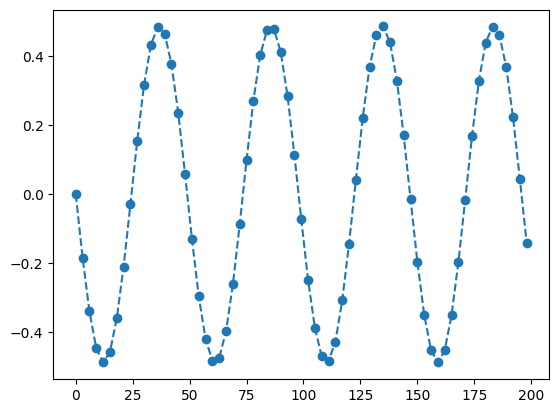

In [17]:
A, P = getAandP()
amp = A[0]
period = P[0]
x, npts = getXvalues()
t, y = getData(x, amp, period)
plt.scatter(t, y, label='Data Points')
plt.plot(x, amp * np.sin(2 * np.pi * x/ period), label='Sine Curve', linestyle='--')
plt.show()

# 2. Generate persistence diagram for each graph

A persistence diagram is a mathematical representation used in topological data analysis to capture and visualize the evolution of topological features in a dataset. In the context of time series data, it represents the birth and death times of connected components.

How I create my persistence diagrams:

1. Edge Creation:
The code first creates edges between adjacent points in the time series. The "distance" along the edges is set to the maximum value of the points it connects.
2. Vertex Birth Times:
Vertex birth times are added along the diagonal of the distance matrix. These birth times are derived from the original time series.
3. Sparse Distance Matrix:
A sparse distance matrix is created using the added edges and birth times. This matrix represents the relationships and distances between points in the time series.
4. Compute Persistence Diagram:
The code then uses the ripser function to compute the persistence diagram from the sparse distance matrix. It focuses on the 0-dimensional homology.
5. Filter Persistence Diagram:
The resulting persistence diagram is filtered to exclude points where the difference between death and birth times is very small (less than 1e-3).
6. Extract Unique Values:
Unique values from the persistence diagram are extracted to obtain birth and death times. This step ensures that infinite values are excluded.



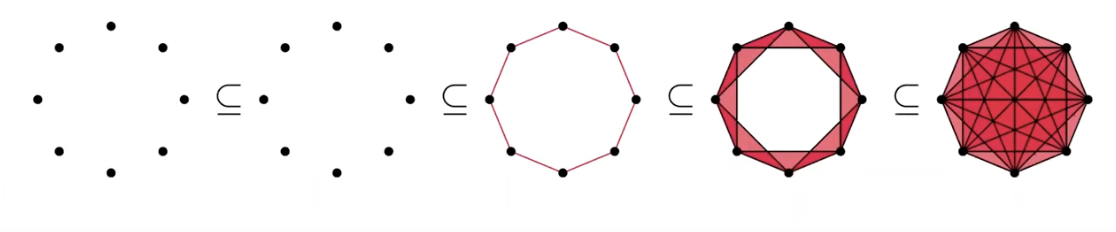

In [6]:
# function to generate persistence diagram
def getPersistenceDiagram(npts, x, y):
    # Add edges between adjacent points in the time series, with the "distance"
    # along the edges equal to the max value of the points it connects
    I = np.arange(npts - 1)
    J = np.arange(1, npts)
    V = np.maximum(y[0: -1], y[1::])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(npts)))
    J = np.concatenate((J, np.arange(npts)))
    V = np.concatenate((V, y))
    # Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape = (npts, npts)).tocsr()
    dgm0 = ripser(D, maxdim = 0, distance_matrix = True)['dgms'][0]
    dgm0 = dgm0[dgm0[:, 1] - dgm0[:, 0] > 1e-3, :]
    allgrid = np.unique(dgm0.flatten())
    allgrid = allgrid[allgrid < np.inf]
    # birth times
    xs = np.unique(dgm0[:, 0])
    ys = np.unique(dgm0[:, 1])
    # death times
    ys = ys[ys < np.inf]

    return dgm0, allgrid, xs, ys


# function to plot the time series and persistence diagrams
def plotDiagrams(x, y, dgm0):
    fig, ax = plt.subplots(2, 1, figsize = (11, 6))
    ax[0].scatter(t, y, marker = 'o', c = 'k', s = 4)
    plot_diagrams(dgm0, size = 50, ax = ax[1])
    plt.show()

**Generate the test data time series and their corresponding persistence diagrams**
- using previosuly defined functions

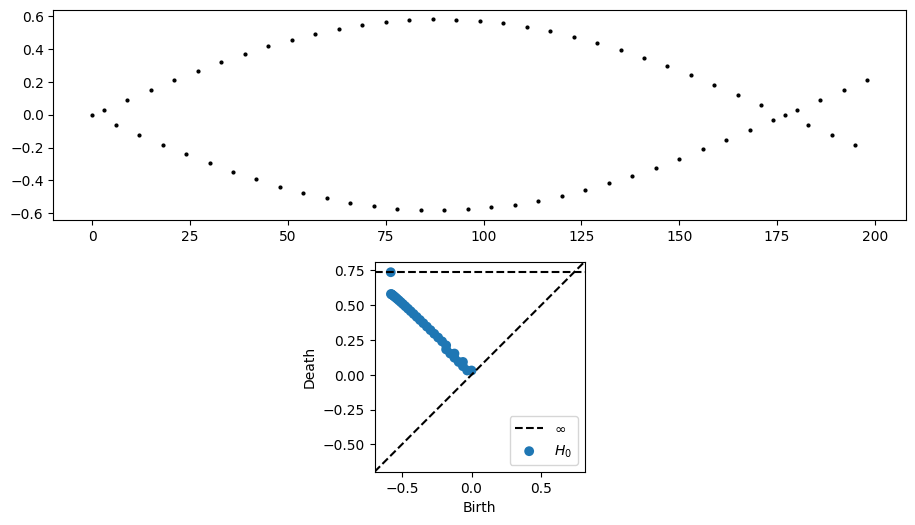

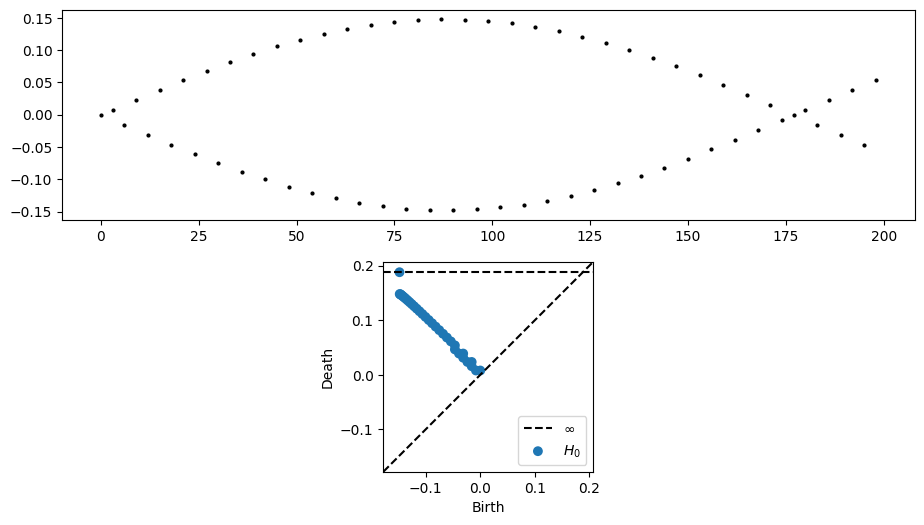

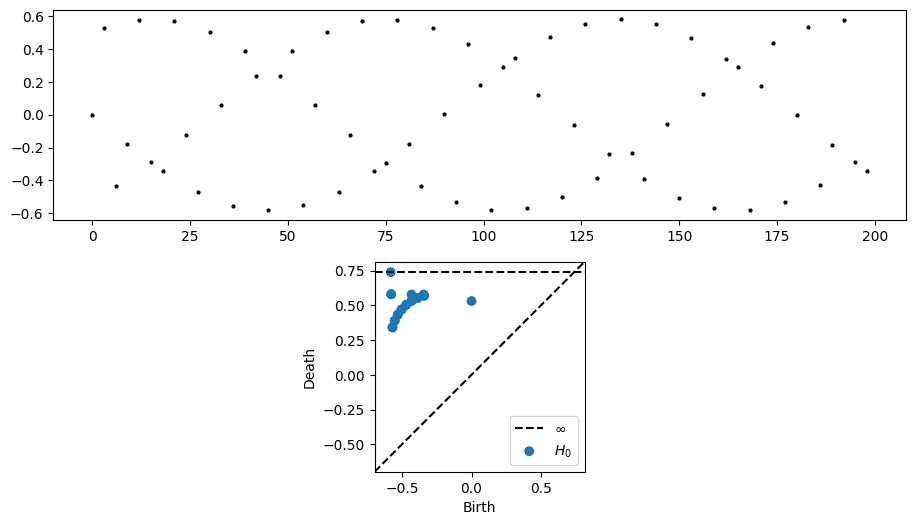

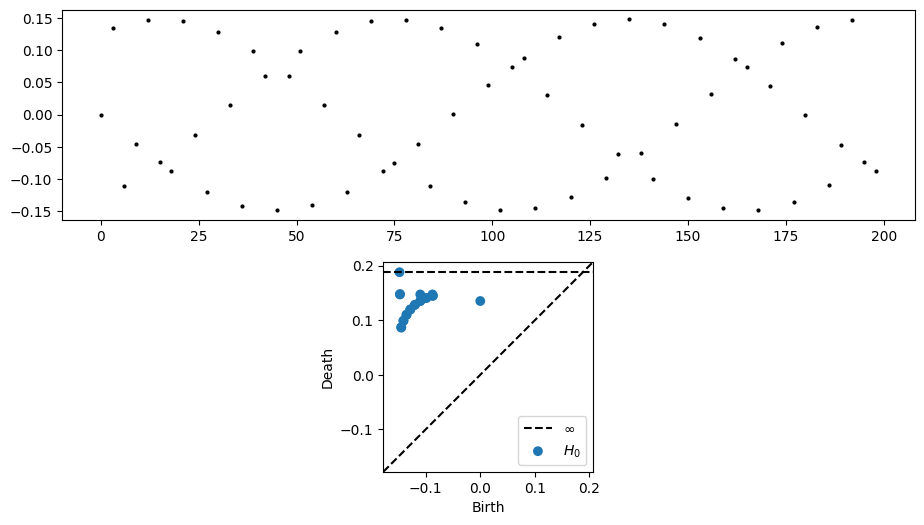

In [8]:
# each time series graph that is generated has its corresponding persistence diagram.
# We are generating 400 sample normal time series graphs, i.e we get 400 persistence diagrams each.
# we want to add each persistence diagram to our overall diagrams array

# initializing diagrams array
diagrams = []
# getting the relavant data:
A, P = getAandP()
x, npts = getXvalues()

index = 0
for i, period in enumerate(P):
    for j, amplitude in enumerate(A):
      t, y = getData(x, amplitude, period)
      dgm0, allgrid, xs, ys = getPersistenceDiagram(npts, t, y)
      diagrams.insert(index, dgm0)
      index += 1
      if i < 2 and j < 2:
        plotDiagrams(t, y, dgm0)

# For visualization purpose -
# Plotting the time series test data graphs and their corresponding
# persistence diagrams for the first 4 values in the dataset


**Generate 4 outlier graphs and their persistence diagrams**
- and then add it to the diagrams list

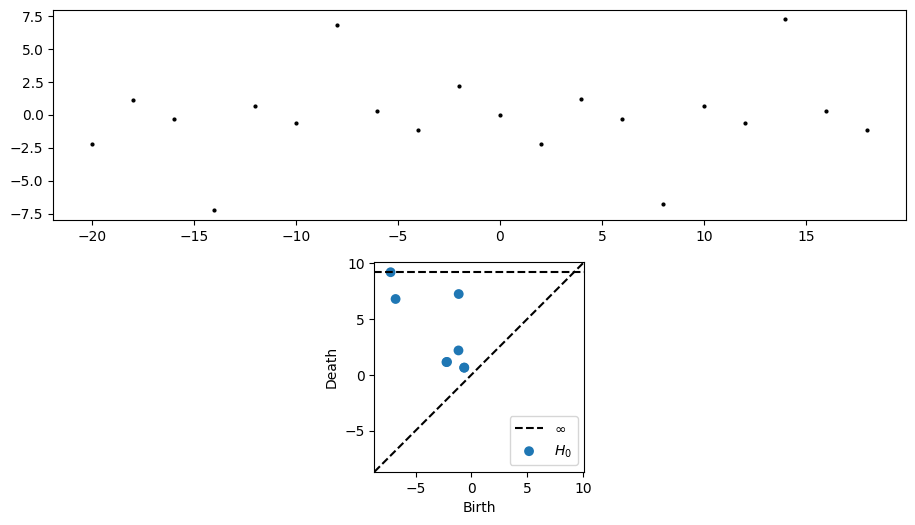

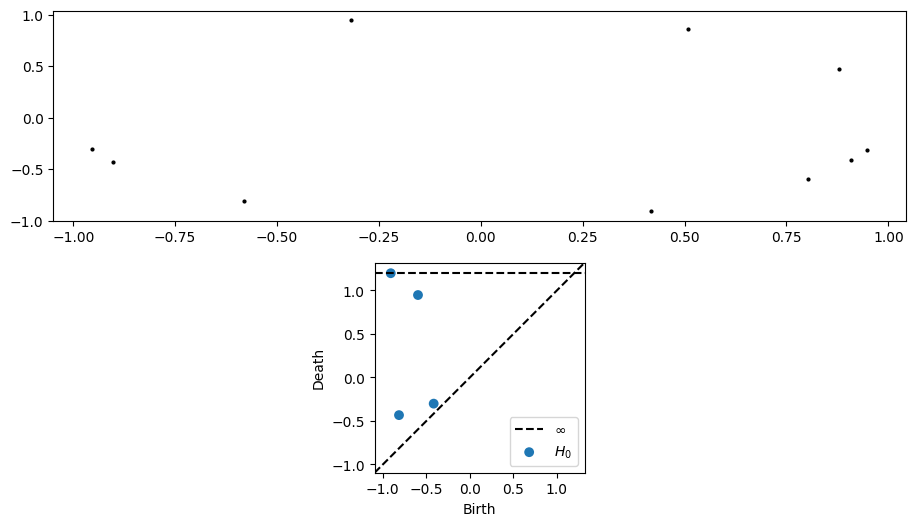

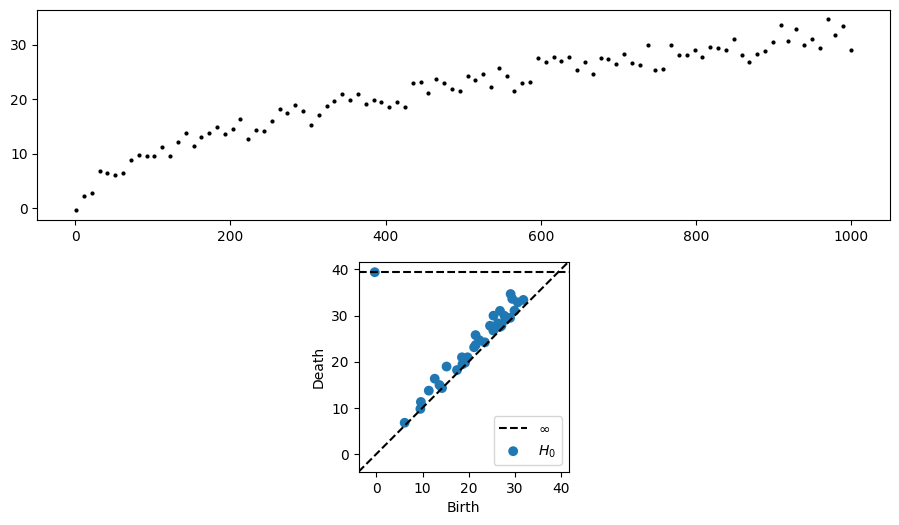

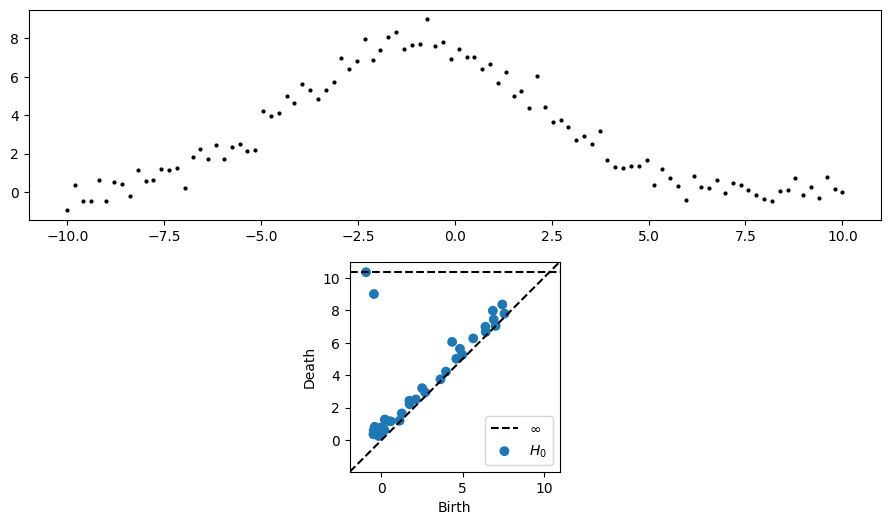

In [9]:
# generating persistence diagram for tan anomalies
t, y, npts = getTanAnomalies()
outlier1_dgm0, allgrid, xs, ys = getPersistenceDiagram(npts, t, y)
plotDiagrams(t, y, outlier1_dgm0)
diagrams.append(outlier1_dgm0) #400

# generating persistence diagram for tan anomalies
t, y, npts = getCircleAnomalies()
outlier2_dgm0, allgrid, xs, ys = getPersistenceDiagram(npts, t, y)
plotDiagrams(t, y, outlier2_dgm0)
diagrams.append(outlier2_dgm0) #401

# generating persistence diagram for tan anomalies
t, y, npts = getWhiteNoise()
outlier3_dgm0, allgrid, xs, ys = getPersistenceDiagram(npts, t, y)
plotDiagrams(t, y, outlier3_dgm0)
diagrams.append(outlier3_dgm0) #402

# generating persistence diagram for tan anomalies
t, y, npts = getGaussianAnomalies()
outlier4_dgm0, allgrid, xs, ys = getPersistenceDiagram(npts, t, y)
plotDiagrams(t, y, outlier4_dgm0)
diagrams.append(outlier4_dgm0) #403


# For visualization purpose -
# Plotting the anomolous test data graphs and their persistence diagrams

# 3: Compare persistence diagrams using WS distance metric, to produce a distance matrix
Compare all the persistence diagrams against each other and note the Wasserstein distance between each persistence diagram to create a distance matrix

**What is the wasserstein distance metric and why do we use it?**

The Wasserstein distance, also known as the Earth Mover's Distance (EMD), is a metric that quantifies the dissimilarity between two probability distributions over a metric space. It measures the minimum "cost" required to transform one distribution into the other, where the cost is interpreted as the amount of "work" needed to move mass from one distribution to the other.

In [18]:
# computing the distance matrix
# by comparing each persistence diagram to the other diagrams
# comparision done using wasserstein distance metric

mylist = diagrams.copy()
dist_matrix = []
diff_list = []
for i in range(len(mylist)):
    for j in range(len(mylist)):
        # Compute the Wasserstein distance between each persistence diagram
        temp = persim.wasserstein(mylist[i], mylist[j], matching = False)
        diff_list.append(temp)
    # comparing each persistence diagram to every other PD
    # appending the values of the distances to final distance matrix
    dist_matrix.insert(i, diff_list)
    diff_list = []


AttributeError: ignored

# 4: Apply Isolation Forest on this distance matrix to identify outliers

Outliers index in the array of graphs are:
  (array([  3,   6,  16,  18,  23,  63,  79,  83,  86, 103, 119, 123, 126,
       139, 143, 159, 163, 166, 176, 178, 179, 203, 219, 223, 243, 259,
       263, 266, 276, 278, 279, 283, 303, 306, 318, 319, 323, 339, 343,
       363, 379, 383, 400, 402, 403]),)




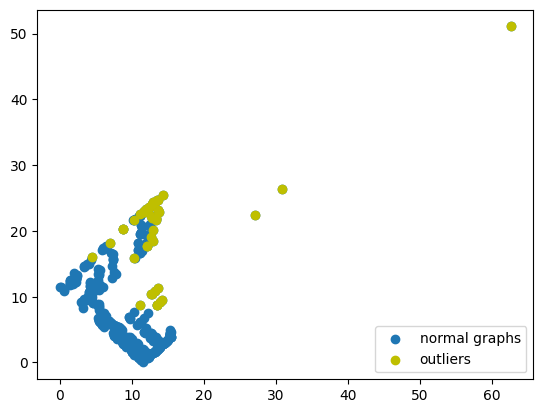

In [25]:
dist_matrix = np.array(dist_matrix)
# Initialize and fit the Isolation Forest model
IF = IsolationForest(n_estimators=100)
predictions = IF.fit_predict(dist_matrix)

# Get the indices of outliers
outlier_index = where(predictions==-1)
print ("Outliers index in the array of graphs are:\n ", outlier_index)
print ('\n')
# Visualize the outliers in the distance matrix
fig, ax = plt.subplots()
values = dist_matrix[outlier_index]
ax.scatter(dist_matrix[:,0], dist_matrix[:,1], label = 'normal graphs')
ax.scatter(values[:,0], values[:,1], color='y', label = 'outliers')
leg = ax.legend(loc ="lower right");

# Analysis of Results

**Expected result -**
* 43 anomalies
* 3 anomalies - We added 4 anomalies to the data, but circle graph anomaly does not get picked up as an anomaly because it can also be modelled by an underlying sine curve.
* 40 anomalies in generated test data - we generate our amplitude and period values using a gaussian distribution. This means that there are amplitude and period values that would be considered anomalies because they lie in the edges of the bell curve. This is what is picked up by the algorithm.


**Actual Result**
* 45 anomalies detected


**Code performance on telescope data**

* True positive rate above 99%
* False positive rate -  0.207%
only 3 of the 1450 time series were detected as anomalies when they were in reality a “normal” graph and not an anomaly.
